🚀 Mengunduh dan menginisialisasi file Haar Cascade...
✅ Haar Cascade berhasil diinisialisasi.
------------------------------
📁 Folder output Colab 'image_data_output' berhasil dibuat.
------------------------------
⬇ LANGKAH 3a: Silakan unggah file Label TXT (Label.txt) jika ada (jika tidak ada/kosong, pelabelan tetap otomatis).


Saving Jokowi.jpg to Jokowi.jpg
⚠ Peringatan: File 'Label.txt' tidak ditemukan. Semua gambar akan dilabeli otomatis berdasarkan nama file.

⬇ LANGKAH 3c: Silakan unggah *semua file Gambar JPG/JPEG* Anda.


Saving bahlil.jpg to bahlil.jpg
🖼 Total 1 gambar berhasil diunggah.
------------------------------

>>>> MEMPROSES FILE: bahlil.jpg <<<<
   [Label Otomatis] -> Menggunakan nama file sebagai label: *bahlil*
   Ditemukan 1 wajah pada gambar.
      - Wajah 1 tersimpan dan ditambahkan ke rekaman JSON.


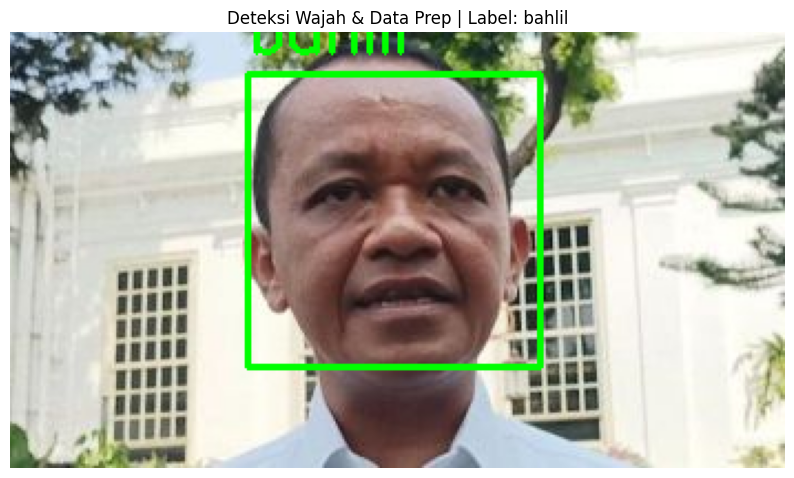


✅ SEMUA GAMBAR SELESAI DIPROSES. Total 1 wajah.
💾 *Data Recognition telah disimpan/diperbarui ke: Data_Recognition.json*
📦 Mengompres hasil ke face_data_collection.zip...
⬇ Mengunduh face_data_collection.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- INSTRUKSI PENTING UNTUK LOKASI FILE ---
1. File *face_data_collection.zip* telah diunduh.
2. *Ekstrak* isi file ZIP tersebut.
3. Pindahkan folder hasil ('image_data_output') ke lokasi tujuan Anda:
   *C:\Users\ricky\Downloads\Image\*
---------------------------------------------


In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import shutil
import json
from google.colab import files

# --- Konfigurasi File ---
HAAR_CASCADE_URL = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'
HAAR_CASCADE_FILENAME = 'haarcascade_frontalface_default.xml'
OUTPUT_FOLDER = 'image_data_output'
LABEL_FILE = 'Label.txt' # <-- Menggunakan TXT
DATA_OUTPUT_JSON = 'Data_Recognition.json'
ZIP_FILENAME = 'face_data_collection.zip'

# --- Fungsi Utility untuk Pelabelan Otomatis ---
def get_label_from_txt_or_filename(image_name, label_data_map):
    """
    Fungsi ini menjamin pelabelan otomatis dari nama file JPG
    jika tidak ada entri di Label.txt (label_data_map).
    """
    search_key = image_name.lower()
    person_label = label_data_map.get(search_key)

    if person_label:
        # Jika ditemukan di Label.txt (optional)
        print(f"   [Label Ditemukan] -> Label dari TXT: *{person_label}*")
        return person_label
    else:
        # OTOMATIS MENGGUNAKAN NAMA FILE SEBAGAI LABEL
        base_name = os.path.splitext(image_name)[0]
        auto_label = base_name.replace(" ", "_")

        print(f"   [Label Otomatis] -> Menggunakan nama file sebagai label: *{auto_label}*")
        return auto_label

# --- Langkah 1: Mengunduh Haar Cascade ---
print("🚀 Mengunduh dan menginisialisasi file Haar Cascade...")
!wget -q {HAAR_CASCADE_URL}
face_cascade = cv2.CascadeClassifier(HAAR_CASCADE_FILENAME)
print("✅ Haar Cascade berhasil diinisialisasi.")
print("-" * 30)

# --- Langkah 2: Mempersiapkan Folder Output ---
if os.path.exists(OUTPUT_FOLDER):
    shutil.rmtree(OUTPUT_FOLDER)
os.makedirs(OUTPUT_FOLDER)
print(f"📁 Folder output Colab '{OUTPUT_FOLDER}' berhasil dibuat.")

data_recognition = []
label_data_map = {}
print("-" * 30)

# --- Langkah 3: Mengunggah File Label TXT dan Gambar (Multi-Upload) ---

# 3a. Unggah File Label TXT (Opsional: akan tetap bekerja jika tidak diunggah/kosong)
print(f"⬇ LANGKAH 3a: Silakan unggah file Label TXT ({LABEL_FILE}) jika ada (jika tidak ada/kosong, pelabelan tetap otomatis).")
uploaded_txt = files.upload()

if LABEL_FILE in uploaded_txt:
    # 3b. Memuat Label dari TXT ke dalam Map
    try:
        with open(LABEL_FILE, 'r') as f:
            for line in f:
                line = line.strip()
                if line and ':' in line:
                    key_part, value_part = line.split(':', 1)
                    key_part = key_part.strip().lower()
                    value_part = value_part.strip()
                    label_data_map[key_part] = value_part

        print(f"✅ Label TXT berhasil dimuat. Total {len(label_data_map)} label terdaftar (Opsional).")
    except Exception as e:
        print(f"⚠ Peringatan: Gagal memuat Label.txt ({e}). Semua gambar akan dilabeli otomatis berdasarkan nama file.")
        label_data_map = {}
else:
    print(f"⚠ Peringatan: File '{LABEL_FILE}' tidak ditemukan. Semua gambar akan dilabeli otomatis berdasarkan nama file.")


# 3c. Unggah File Gambar (Multi-File)
print("\n⬇ LANGKAH 3c: Silakan unggah *semua file Gambar JPG/JPEG* Anda.")
uploaded_images = files.upload()

if not uploaded_images:
    print("❌ ERROR: Tidak ada gambar yang diunggah. Kode berhenti.")
    exit()

image_names = list(uploaded_images.keys())
print(f"🖼 Total {len(image_names)} gambar berhasil diunggah.")

print("-" * 30)


# --- Langkah 4: Fungsi Deteksi Wajah, Cropping, dan Penyimpanan Data ke JSON ---
def process_faces_for_recognition(image_path, cascade_classifier, output_dir, label, data_list):
    TARGET_SIZE = (50, 50)
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        return 0

    img_display = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    faces = cascade_classifier.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    print(f"   Ditemukan {len(faces)} wajah pada gambar.")

    for i, (x, y, w, h) in enumerate(faces):
        face_crop = img_bgr[y:y+h, x:x+w]
        face_resized = cv2.resize(face_crop, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)

        timestamp = int(time.time() * 1000)
        output_filename = os.path.join(output_dir, f"{label}{timestamp}{i}.jpg")

        cv2.imwrite(output_filename, face_resized)

        data_list.append({
            "path": output_filename,
            "label": label,
            "source_file": os.path.basename(image_path)
        })

        print(f"      - Wajah {i+1} tersimpan dan ditambahkan ke rekaman JSON.")

        cv2.rectangle(img_display, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img_display, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_display)
    plt.title(f"Deteksi Wajah & Data Prep | Label: {label}")
    plt.axis('off')
    plt.show()

    return len(faces)

# --- Langkah 5: Eksekusi Iteratif ---
total_wajah_diproses = 0

for image_name in image_names:
    print(f"\n>>>> MEMPROSES FILE: {image_name} <<<<")

    person_label = get_label_from_txt_or_filename(image_name, label_data_map)

    if os.path.exists(image_name):
        face_count = process_faces_for_recognition(image_name, face_cascade, OUTPUT_FOLDER, person_label, data_recognition)
        total_wajah_diproses += face_count
    else:
        print(f"❌ ERROR: File gambar '{image_name}' tidak ditemukan di sistem Colab.")

print("\n" + "="*50)
print(f"✅ SEMUA GAMBAR SELESAI DIPROSES. Total {total_wajah_diproses} wajah.")
print("="*50)


# --- Langkah 6: Penyimpanan Akhir, Kompresi, dan Unduh ---

with open(DATA_OUTPUT_JSON, 'w') as f:
    json.dump(data_recognition, f, indent=4)

print(f"💾 *Data Recognition telah disimpan/diperbarui ke: {DATA_OUTPUT_JSON}*")

# Pindahkan semua file output ke folder zip
if os.path.exists(DATA_OUTPUT_JSON):
    shutil.move(DATA_OUTPUT_JSON, os.path.join(OUTPUT_FOLDER, DATA_OUTPUT_JSON))
if os.path.exists(LABEL_FILE):
    shutil.move(LABEL_FILE, os.path.join(OUTPUT_FOLDER, LABEL_FILE))

print(f"📦 Mengompres hasil ke {ZIP_FILENAME}...")
shutil.make_archive(OUTPUT_FOLDER, 'zip', OUTPUT_FOLDER)

# UNDUH FILE ZIP
print(f"⬇ Mengunduh {ZIP_FILENAME}...")
files.download(f'{OUTPUT_FOLDER}.zip')

print("\n--- INSTRUKSI PENTING UNTUK LOKASI FILE ---")
print(f"1. File *{ZIP_FILENAME}* telah diunduh.")
print("2. *Ekstrak* isi file ZIP tersebut.")
print(f"3. Pindahkan folder hasil ('{OUTPUT_FOLDER}') ke lokasi tujuan Anda:")
print(f"   *C:\\Users\\ricky\\Downloads\\Image\\*")
print("---------------------------------------------")